In [ ]:
import os
import sys

if 'google.colab' in sys.modules:       # Si on est dans Google Colab
    # Colab : Monter Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    project_path = '/content/drive/MyDrive/internship_cvut'
else:
    # Exécution locale : on se base sur le chemin du fichier
    project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..'))

# Changer le dossier courant vers le dossier du projet
os.chdir(project_path)

# Ajouter src/ au path si nécessaire
src_path = os.path.join(project_path, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Optionnel : vérifier que tout est bien configuré
# print("Répertoire courant :", os.getcwd())
# print("Contenu de src :", os.listdir(src_path))
# print("Contenu de database :", os.listdir(os.path.join(project_path, 'database')))

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from python_scripts.miscellaneaous.data_processing import extract_data
from python_scripts.road_detection.road_utils import *

In [ ]:
# Chargement des données
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider='Orange') #, techno='4g')#, region='Normandie')
xy = df[['x', 'y']].to_numpy()

/tmp/ipython-input-2049708138.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


## Calculs divers



### Distance

#### Distance moyenne/max/min aux k plus proches voisins, hors ville

/tmp/ipython-input-1010495508.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


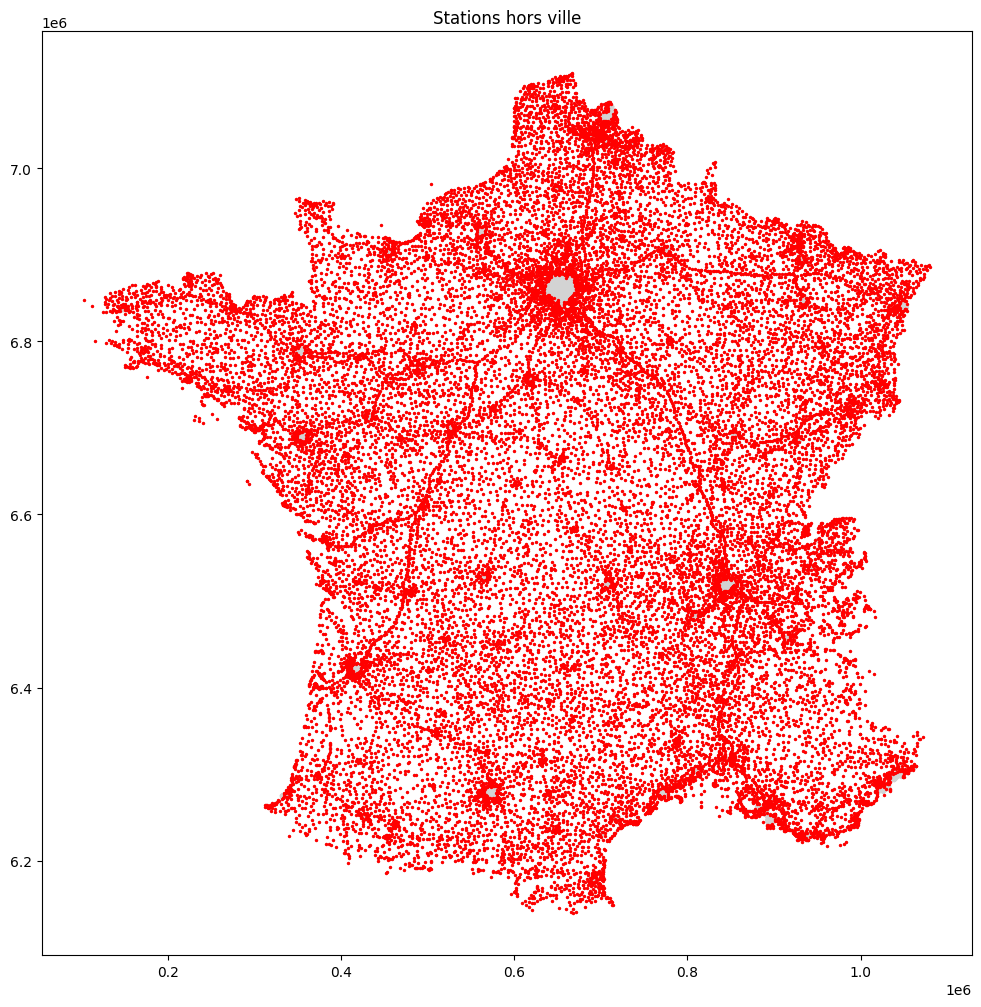

5593.6788066103745
32891.24965701364
0.0
6551.4393021832975
32891.24965701364
0.0


In [ ]:
from scipy.spatial.distance import pdist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider="Orange") #, region='Normandie', techno="4G")
df = df[df["nom_reg"] != "Corse"]    # On retire la Corse car trop loin


xy = df[['x', 'y']].to_numpy()


# Paramètres  #5 1000 pour tout opérateurs,  Orange seul : 10, 2500
k = 15
seuil_dist_ville = 2000  # Si la moyenne des distances aux k plus proches voisins d'une station est inférieure, alors c'est en ville

# Recherche des k+1 plus proches voisins (le 1er est le point lui-même)
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(xy)
distances, _ = nbrs.kneighbors(xy)

# On exclut la première colonne (distance à soi-même = 0)
distances_to_k = distances[:, 1:]

# Suppression des stations en ville
distances_moyennes = distances_to_k.mean(axis=1)    # Moyenne des distances aux k voisins (excluant soi-même) pour chaque point
masque = distances_moyennes >= seuil_dist_ville     # Masque des points dont la moyenne est supérieure ou égale au seuil
points_hors_ville = xy[masque]                      # Retourne uniquement les points hors zone dense
distances_to_k_hors_ville = distances_to_k[masque]             # Idem pour les distances

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(xy[:, 0], xy[:, 1], s=2, c='lightgray', label='Stations')
ax.set_title("Stations hors ville")
ax.scatter(points_hors_ville[:, 0], points_hors_ville[:, 1], s=2, c='red', label='Stations hors ville')
ax.set_aspect('equal')
plt.show()

print(distances_to_k.mean())
print(distances_to_k.max())
print(distances_to_k.min())

print(distances_to_k_hors_ville.mean())
print(distances_to_k_hors_ville.max())
print(distances_to_k_hors_ville.min())

#### Nombre de stations selon la distance aux k plus proches voisins


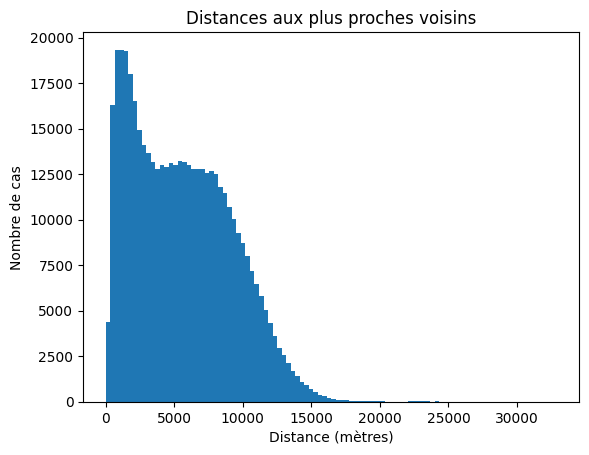

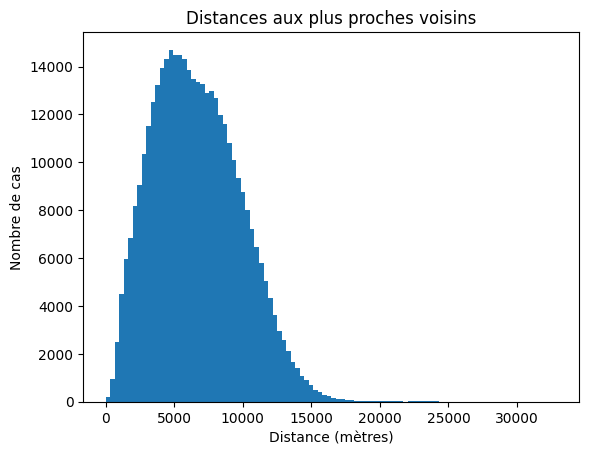

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 15

nn = NearestNeighbors(n_neighbors=k+1).fit(xy)
dists, _ = nn.kneighbors(xy)

import matplotlib.pyplot as plt

plt.hist(dists[:, 1:].flatten(), bins=100)
plt.title("Distances aux plus proches voisins")
plt.xlabel("Distance (mètres)")
plt.ylabel("Nombre de cas")
plt.show()

# hors ville
nn = NearestNeighbors(n_neighbors=k+1).fit(xy[masque])
dists, _ = nn.kneighbors(xy[masque])

plt.hist(dists[:, 1:].flatten(), bins=100)
plt.title("Distances aux plus proches voisins")
plt.xlabel("Distance (mètres)")
plt.ylabel("Nombre de cas")
plt.show()

Premier pic : villes (densité de stations très forte). Le reste : axes et campagne, donc 2eme pic : axes.

### Angle

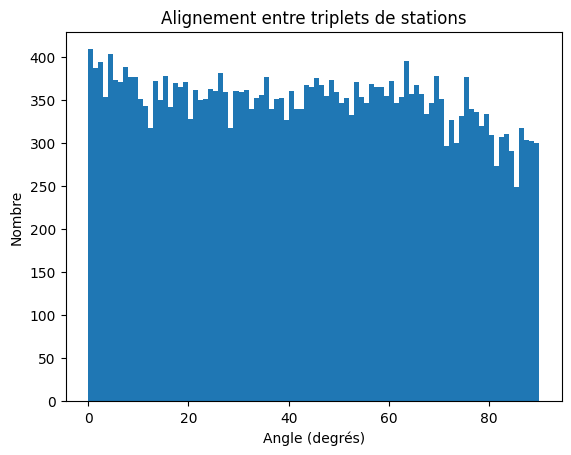

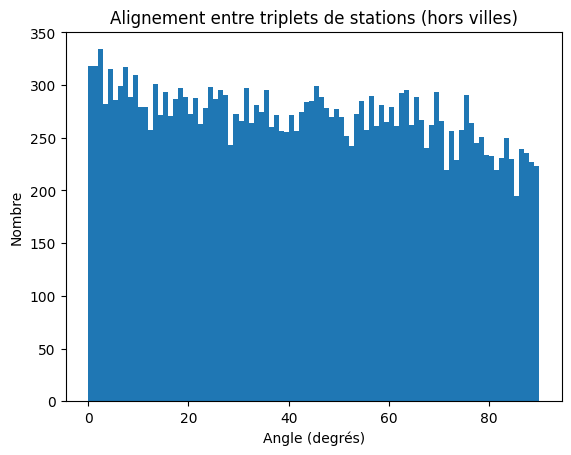

In [ ]:
def angles_from_triplets(xy, nn_model):
    angles = []
    for i in range(len(xy)):
        dists, inds = nn_model.kneighbors([xy[i]], n_neighbors=3)
        if len(inds[0]) < 3:
            continue
        a, b, c = xy[inds[0]]
        v1 = b - a
        v2 = c - b
        angle = angle_between(v1, v2)
        angle = min(angle, 180 - angle)  # for alignment (0-90 angle)
        angles.append(angle)
    return angles

# En ville

angles = angles_from_triplets(xy, nn)
plt.hist(angles, bins=90)
plt.title("Alignement entre triplets de stations")
plt.xlabel("Angle (degrés)")
plt.ylabel("Nombre")
plt.show()

# Hors ville

xy_non_city = xy[masque]
nn_non_city = NearestNeighbors(n_neighbors=10).fit(xy_non_city)

angles_non_city = angles_from_triplets(xy_non_city, nn_non_city)

plt.hist(angles_non_city, bins=90, range = (0, 90))
plt.title("Alignement entre triplets de stations (hors villes)")
plt.xlabel("Angle (degrés)")
plt.ylabel("Nombre")
plt.show()

In [ ]:
# A CHANGER
angles = angles #_non_city


aligned_threshold = 15   # en degrés
aligned_ratio = np.mean(np.array(angles) < aligned_threshold)
print(f"Proportion de triplets bien alignés (< {aligned_threshold}°) : {aligned_ratio:.2%}")

q50 = np.percentile(angles, 50)
q75 = np.percentile(angles, 75)
q90 = np.percentile(angles, 90)

print(f"Médiane des angles : {q50:.1f}°")
print(f"75e percentile : {q75:.1f}°")
print(f"90e percentile : {q90:.1f}°")

Proportion de triplets bien alignés (< 15°) : 18.26%
Médiane des angles : 43.0°
75e percentile : 65.1°
90e percentile : 79.4°


Pas trop de résultat ici, je reste sur 80° pour l'angle pour ne pas louper des stations le long d'une route, et de toute façon mes nouvelles méthodes considèrent juste le meilleur angle avec cette valeur en maximum, c'est cohérent.

### Carte chaleur densité

/tmp/ipython-input-532568359.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


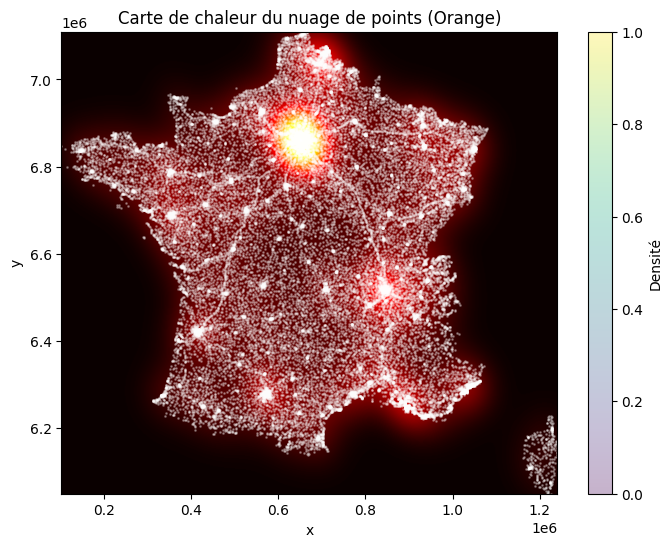

/tmp/ipython-input-532568359.py:35: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


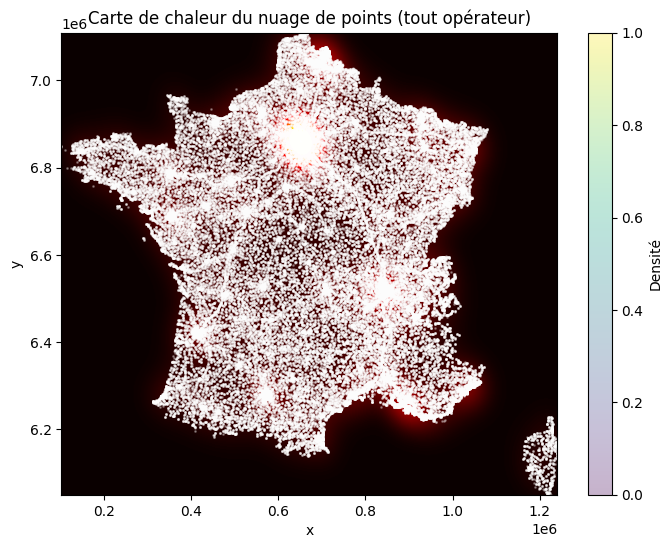

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider="Orange") #, region='Normandie', techno="4G")

# Extraction des colonnes x et y
xy = df[['x', 'y']].to_numpy()
x, y = xy[:, 0], xy[:, 1]

# Transposer les données pour gaussian_kde
kde = gaussian_kde(xy.T)

# Créer une grille
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Évaluer la densité
density = np.reshape(kde(positions).T, xx.shape)

# Affichage
plt.figure(figsize=(8, 6))
plt.imshow(density.T, origin='lower', cmap='hot', extent=[xmin, xmax, ymin, ymax], aspect='auto')
plt.scatter(x, y, s=1, c='white', alpha=0.3)
plt.colorbar(label='Densité')
plt.title('Carte de chaleur du nuage de points (Orange)')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df) #, region='Normandie', techno="4G")

# Extraction des colonnes x et y
xy = df[['x', 'y']].to_numpy()
x, y = xy[:, 0], xy[:, 1]

# Transposer les données pour gaussian_kde
kde = gaussian_kde(xy.T)

# Créer une grille
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Évaluer la densité
density = np.reshape(kde(positions).T, xx.shape)

plt.figure(figsize=(8, 6))
plt.imshow(density.T, origin='lower', cmap='hot', extent=[xmin, xmax, ymin, ymax], aspect='auto')
plt.scatter(x, y, s=1, c='white', alpha=0.3)
plt.colorbar(label='Densité')
plt.title('Carte de chaleur du nuage de points (tout opérateur)')
plt.xlabel("x")
plt.ylabel("y")
plt.show()